## Cargamos los datos

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Creamos la sesión 
spark = SparkSession.builder \
    .appName("EDA_pyspak") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.executor.instances", "2") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()  

# Caragamos los datos
originalData = spark.read.option("header","true").csv("original_data.csv")

# Creamos una tabla temporal para hacer consultas tipo sql
originalData.createOrReplaceTempView('originalData')

# ELiminamos la primer columna
originalData=originalData.drop('ID_code')

# Corregimos el tipo de dato a flotante para todos los datos
for column in originalData.columns:
    originalData = originalData.withColumn(column, originalData[column].cast(FloatType()))

# Función para eliminar completamente dataframes de pyspark
def borrar(dataframe):
    """
    Función para eliminar tanto el caché como un dataframe que ya no se utilizará 
    Args:
        datagrame (DataFrame): Dataframe a eliminar
    """
    dataframe.unpersist()
    del dataframe

24/08/07 14:58:43 WARN Utils: Your hostname, proyectosrym resolves to a loopback address: 127.0.1.1; using 148.204.64.184 instead (on interface eno1)
24/08/07 14:58:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/07 14:58:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/07 14:58:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Análisis de Componentes Principales (con pyspark)

In [2]:
# Columnas de características
feature_columns = originalData.columns[1:]

# Convertir las columnas de características en un vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_with_features = assembler.transform(originalData)

# Aplicar PCA
pca = PCA(k=len(feature_columns), inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(data_with_features)
pca_result = pca_model.transform(data_with_features)

# Obtener la varianza explicada por cada componente principal
explained_variance = pca_model.explainedVariance.toArray()

# Calcular el porcentaje de varianza explicada acumulada
cumulative_variance = [sum(explained_variance[:i+1]) for i in range(len(explained_variance))]

# Convertir los valores a float
cumulative_variance = [float(x) for x in cumulative_variance]

# Crear un DataFrame con los resultados
cumulative_variance_df = spark.createDataFrame([
    (i+1, cumulative_variance[i]) 
    for i in range(len(cumulative_variance))
], ["Principal Component", "Cumulative Variance"])

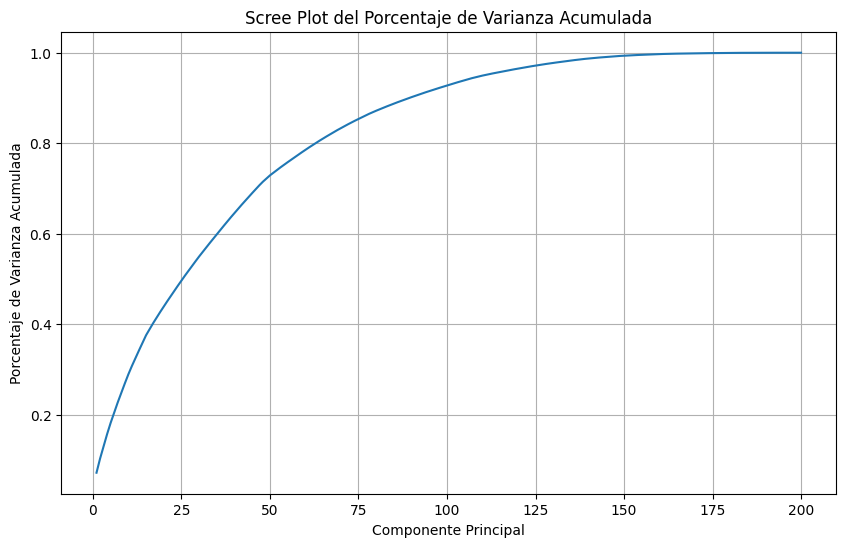

DataFrame[Principal Component: bigint, Cumulative Variance: double]

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 

# Convertir a Pandas DataFrame para visualización
cumulative_variance_pd = cumulative_variance_df.toPandas()

# Crear el Scree Plot del porcentaje de varianza acumulada
plt.figure(figsize=(10, 6))
sns.lineplot(x='Principal Component', y='Cumulative Variance', data=cumulative_variance_pd)
plt.title('Scree Plot del Porcentaje de Varianza Acumulada')
plt.xlabel('Componente Principal')
plt.ylabel('Porcentaje de Varianza Acumulada')
plt.grid(True)
plt.show()

# Borramos el dataframe y el caché que no utilizaremos
del cumulative_variance_pd
cumulative_variance_df.unpersist()

## Reducción de la dimensionalidad de los datos (79 componentes principales de 200)

Con base al gráfico anterior, reduciremos la dimensionalidad de los datos a 79 componentes principales

In [4]:
# Excluir la columna 'target' y crear una lista con los nombres de las columnas de características
feature_columns = originalData.columns[1:]

# Convertir las columnas de características en un vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_with_features = assembler.transform(originalData)

# Aplicar PCA para reducir la dimensionalidad a 79 componentes principales
pca = PCA(k=79, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(data_with_features)
pca_result = pca_model.transform(data_with_features)


# Eliminamos las columnas que ya no utilizaremos del dataframe
pca_result = pca_result.drop(*feature_columns)
pca_result = pca_result.drop('features')

## Regrsión logística con submuestreo

#### División en datos de entrenamiento y prueba (60-40, pues son demasiado datos)

In [5]:
# Dividimos el dataset en datos de entrenamiento y prueba
train_df_, test_df = pca_result.randomSplit(weights=[0.6,0.4])

# Creamos tablas temporales para cada uno
train_df_.createOrReplaceTempView('train')
test_df.createOrReplaceTempView('test')


# Vemos el total de datos de cada clase (entrenamiento)
print("datos entrenamiento")
spark.sql("""
    SELECT 
        SUM(CASE WHEN target = 0 THEN 1 ELSE 0 END) AS totalTarget0,
        SUM(CASE WHEN target = 1 THEN 1 ELSE 0 END) AS totalTarget1
    FROM train
""").show()


# Vemos el total clases de cada clase (prueba)
print("datos prueba")
spark.sql("""
    SELECT 
        SUM(CASE WHEN target = 0 THEN 1 ELSE 0 END) AS totalTarget0,
        SUM(CASE WHEN target = 1 THEN 1 ELSE 0 END) AS totalTarget1
    FROM test
""").show()


datos entrenamiento


+------------+------------+
|totalTarget0|totalTarget1|
+------------+------------+
|      107823|       12032|
+------------+------------+

datos prueba


+------------+------------+
|totalTarget0|totalTarget1|
+------------+------------+
|       72079|        8066|
+------------+------------+



In [6]:
12032/107800*100, 8066/72102*100

(11.161410018552875, 11.186929627472193)

### Submuestreo para el entrenamiento

In [7]:
from pyspark.sql.functions import rand

# Dividimos los datos según la etiqueta y creamos una submuestra de la clase mayoritaria del tamaño de la clase minoritaria
train_df0 = train_df_.filter(train_df_['target']==0).sample(8013/72067)
train_df1 = train_df_.filter(train_df_['target']==1)

In [8]:
# Unimos los datos y los ordenamos aleatoriamente
trainData = train_df0.union(train_df1).select('*').orderBy(rand())
trainData.createOrReplaceTempView('trainData')

# Contamos el número de datos de cada clase
spark.sql('SELECT \
                SUM(CASE WHEN target=0 THEN 1 ELSE 0 END) AS target0,\
                SUM(CASE WHEN target=1 THEN 1 ELSE 0 END) AS target1 \
            FROM trainData').show()

+-------+-------+
|target0|target1|
+-------+-------+
|  11844|  12032|
+-------+-------+



## Entrenamiento regresión logística

In [9]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Crear el modelo de regresión logística
lr = LogisticRegression(labelCol="target", featuresCol="pcaFeatures")

# Configurar la búsqueda de hiperparámetros
paramGrid = (ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.1, 1.0])  # Regularization parameter
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # Elastic Net mixing parameter
    .addGrid(lr.fitIntercept, [True, False])  # Fit intercept or not
    .addGrid(lr.standardization, [True, False])  # Standardize features or not
    .addGrid(lr.tol, [1e-6, 1e-4, 1e-2])  # Convergence tolerance
    .build())

# Evaluador
evaluator = BinaryClassificationEvaluator(labelCol="target")

# Configurar el CrossValidator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # Número de pliegues para la validación cruzada

# Entrenar el modelo
cv_model = crossval.fit(trainData)

# Evaluar el modelo en el conjunto de prueba
predictions = cv_model.transform(test_df)
auc = evaluator.evaluate(predictions)
print(f"AUC en el conjunto de prueba: {auc}")

# Imprimir los mejores parámetros encontrados
best_model = cv_model.bestModel
print(f"Mejor parámetro de regularización: {best_model._java_obj.getRegParam()}")
print(f"Mejor parámetro de Elastic Net: {best_model._java_obj.getElasticNetParam()}")
print(f"Mejor ajuste de intercepto: {best_model._java_obj.getFitIntercept()}")
print(f"Mejor estandarización: {best_model._java_obj.getStandardization()}")
print(f"Mejor tolerancia: {best_model._java_obj.getTol()}")

AUC en el conjunto de prueba: 0.7546028459688625
Mejor parámetro de regularización: 1.0
Mejor parámetro de Elastic Net: 0.0
Mejor ajuste de intercepto: True
Mejor estandarización: True
Mejor tolerancia: 1e-06


## Visualización de los resultados

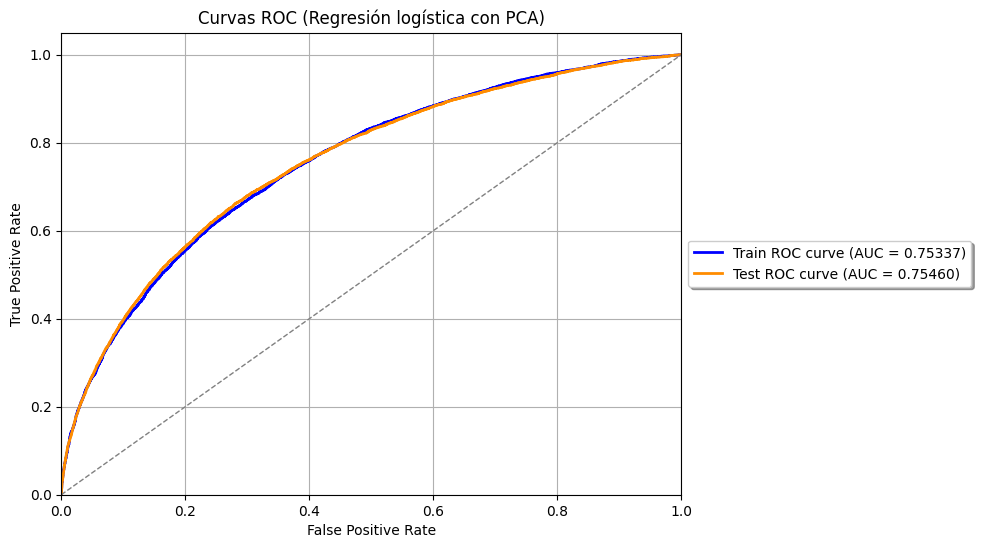

In [11]:
from pyspark.sql.functions import col
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on training data
train_predictions = best_model.transform(trainData)
train_scores = train_predictions.select("target", "probability").rdd.map(lambda row: (float(row["probability"][1]), float(row["target"]))).collect()

# Predict on test data
test_predictions = best_model.transform(test_df)
test_scores = test_predictions.select("target", "probability").rdd.map(lambda row: (float(row["probability"][1]), float(row["target"]))).collect()

# Extract scores and labels for ROC curve
train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

train_fpr, train_tpr, _ = roc_curve(train_scores[:, 1], train_scores[:, 0])
test_fpr, test_tpr, _ = roc_curve(test_scores[:, 1], test_scores[:, 0])

train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, color='blue', lw=2, label=f'Train ROC curve (AUC = {train_auc:.5f})')
plt.plot(test_fpr, test_tpr, color='darkorange', lw=2, label=f'Test ROC curve (AUC = {test_auc:.5f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC (Regresión logística con PCA)')
plt.grid(True)
# Legends
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.show()

### Análisis de umbral de probabilidad

/home/amonroy/ambientes/spark/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/amonroy/ambientes/spark/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/amonroy/ambientes/spark/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/amonroy/am

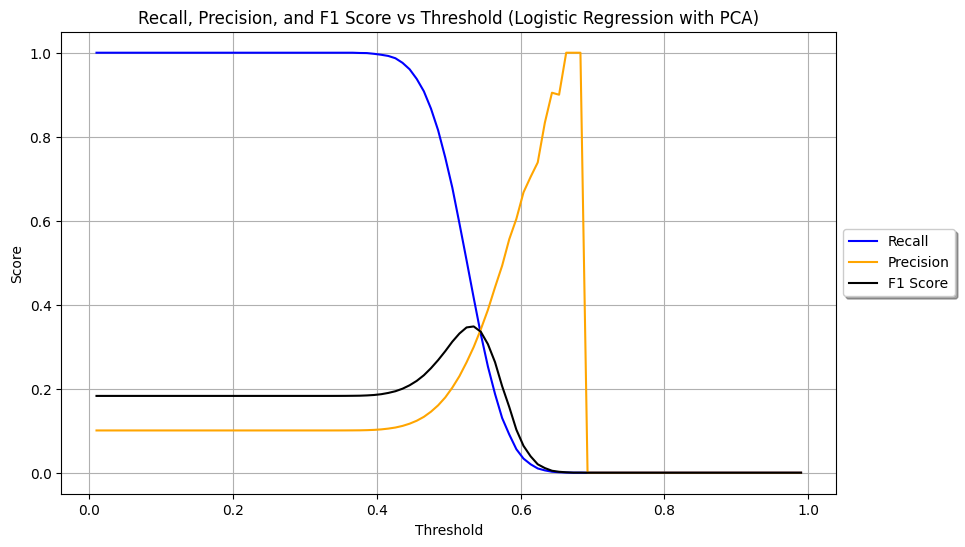

In [13]:
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, f1_score


# Extraer scores y labels
probabilities = test_scores[:, 0]
labels = test_scores[:, 1]

# Calcular las métricas de precisión, recall y F1-score en función del umbral
recalls = []
precisions = []
f1_scores = []

# Iterar sobre diferentes umbrales
thresholds = np.linspace(0.01, 0.99, 100)
for threshold in thresholds:
    # Calcular las predicciones para los datos de prueba basados en el umbral
    pred_labels = [1 if prob > threshold else 0 for prob in probabilities]
    
    # Calcular las métricas
    recall = recall_score(labels, pred_labels)
    precision = precision_score(labels, pred_labels)
    f1 = f1_score(labels, pred_labels)
    
    # Almacenar los valores en las listas
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)

# Graficar Recall, Precision y F1-score vs Umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label='Recall', color='blue')
plt.plot(thresholds, precisions, label='Precision', color='orange')
plt.plot(thresholds, f1_scores, label='F1 Score', color='black')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision, and F1 Score vs Threshold (Logistic Regression with PCA)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.grid(True)
plt.show()

### Matriz de confusión para umbraL de probabilidad = 0.56

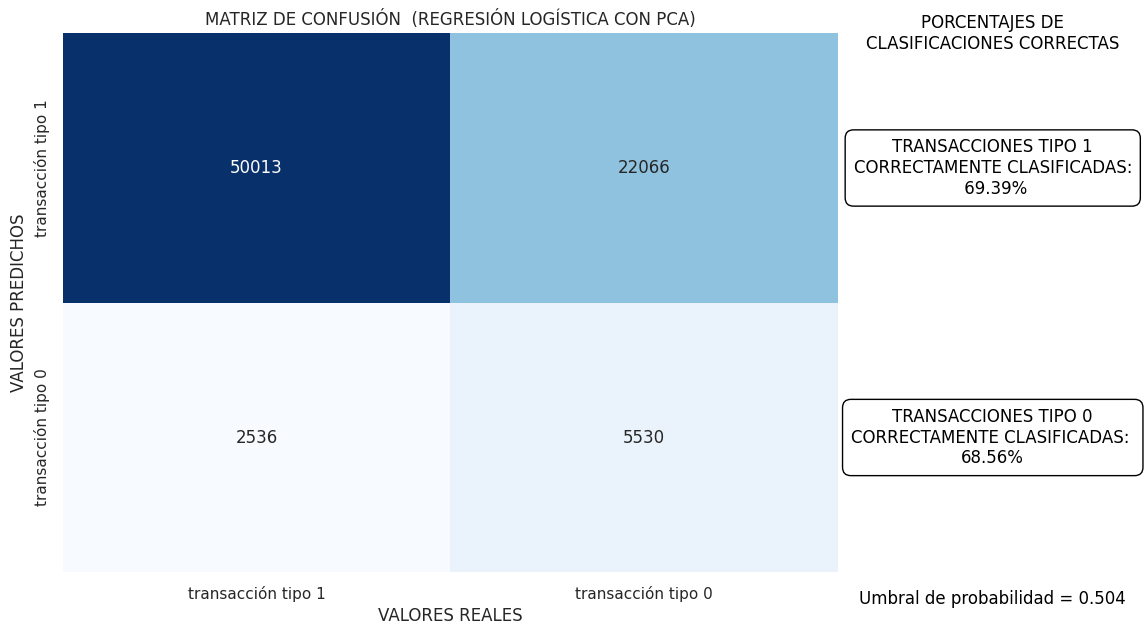

In [35]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

# Definir el umbral de probabilidad
THRESHOLD = 0.504

# Obtener las etiquetas predichas basadas en el umbral
pred_labels = [1 if prob > THRESHOLD else 0 for prob in probabilities]

# Calcular la matriz de confusión
cm = confusion_matrix(labels, pred_labels)

# Crear un DataFrame a partir de la matriz de confusión para una mejor visualización con Seaborn


cm_df = pd.DataFrame(cm, index=['transacción tipo 1', 'transacción tipo 0'],
                     columns=['transacción tipo 1', 'transacción tipo 0'])

# Calcular los porcentajes para una interpretación más fácil
percentage_with_difficulties_correctly_classified = (cm[1, 1] / (cm[1, 0] + cm[1, 1])) * 100
percentage_without_difficulties_correctly_classified = (cm[0, 0] / (cm[0, 0] + cm[0, 1])) * 100

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('MATRIZ DE CONFUSIÓN  (REGRESIÓN LOGÍSTICA CON PCA)')
plt.xlabel('VALORES REALES')
plt.ylabel('VALORES PREDICHOS')

# Añadir leyendas con porcentajes
plt.text(2.4, 0, "PORCENTAJES DE\nCLASIFICACIONES CORRECTAS", 
         fontsize=12, color='black', ha='center', va='center')
plt.text(2.4, 0.5, f'TRANSACCIONES TIPO 1\nCORRECTAMENTE CLASIFICADAS:\n {percentage_without_difficulties_correctly_classified:.2f}%', 
         fontsize=12, color='black', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.text(2.4, 1.5, f'TRANSACCIONES TIPO 0\nCORRECTAMENTE CLASIFICADAS: \n{percentage_with_difficulties_correctly_classified:.2f}%', 
         fontsize=12, color='black', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.text(2.4, 2.1, f"Umbral de probabilidad = {round(THRESHOLD, 3)}", 
         fontsize=12, color='black', ha='center', va='center')
plt.show()
